***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet\Training_and_Analysis\2_FMNIST
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "1" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  1
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Import Dataset : FMNIST

In [4]:
dataset = datasets.F_MNIST(version = 'ALL') # importing CIFAR10 Dataset

Fashion-MNIST dataset: Training have 60,000 samples and testing have 10,000 samples


# Parameters

In [5]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [6]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [7]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [8]:
coarse_to_medium_array = np.zeros(shape=[number_of_classes_c,number_of_classes_m], dtype=np.int32)
medium_to_fine_array = np.zeros(shape=[number_of_classes_m,number_of_classes_f], dtype=np.int32)

c_id = np.argmax(dataset['y_train_coarse'],1)

m_id = np.argmax(dataset['y_train_medium'],1)

f_id = np.argmax(dataset['y_train_fine'],1)

for x in range(len(dataset['y_test_medium'])):
    coarse_to_medium_array[c_id[x]][m_id[x]] = 1
    
for x in range(len(dataset['y_test_fine'])):
    medium_to_fine_array[m_id[x]][f_id[x]] = 1

Matrix_coarse_to_medium_OneHot = tf.constant(coarse_to_medium_array, dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(medium_to_fine_array, dtype=tf.float32)

In [9]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,
               number_of_classes_m, number_of_classes_f, C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=number_of_classes_m)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=number_of_classes_f)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Model Architecture

In [10]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = number_of_classes_c
    no_medium_class = number_of_classes_m
    no_fine_class = number_of_classes_f

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_m_dims = 16
    SCap_c_dims = 16

    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    # input [batch_size, 6, 6, 512], output [batch_size, 2304, 8]
    reshape= keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims), PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshape)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(p_caps)

    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_f_dims, 
                        name="s_caps_medium")(s_caps_f)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                          lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw'],
                         number_of_classes_m, number_of_classes_f))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [11]:
model = get_compiled_model()

## log directory

In [12]:
directory = sysenv.log_dir('2_FMNIST/HD_CapsNet/W_C_loss')

FOLDER CREATED =  ../../logs/2_FMNIST/HD_CapsNet/W_C_loss


In [13]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 28, 28, 64)   640         ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 28, 28, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.cast (TFOpLambda)           (None,)              0           ['tf.math.argmax_4[0][0]']       
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 1)            0           ['tf.math.reduce_sum_2[0][0]']   
                                                                                                  
 tf.math.argmax (TFOpLambda)    (None,)              0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.argmax_1 (TFOpLambda)  (None,)              0           ['prediction_medium[0][0]']      
                                                                                                  
 tf.math.argmax_5 (TFOpLambda)  (None,)              0           ['input_ym[0][0]']               
          

 da)                                                                                              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.multiply[0][0]']       
 )                                                                                                
                                                                                                  
 tf.math.maximum_4 (TFOpLambda)  (None, 10)          0           ['tf.math.subtract_10[0][0]']    
                                                                                                  
 tf.math.subtract_12 (TFOpLambd  (None, 10)          0           ['input_yf[0][0]']               
 a)                                                                                               
                                                                                                  
 tf.math.m

                                                                                                  
 tf.math.multiply_4 (TFOpLambda  (None,)             0           ['tf.math.abs_2[0][0]',          
 )                                                                'tf.math.abs[0][0]']            
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 10)           0           ['tf.math.multiply_16[0][0]',    
                                                                  'tf.math.multiply_18[0][0]']    
                                                                                                  
 tf.math.abs_3 (TFOpLambda)     (None,)              0           ['tf.math.subtract_3[0][0]']     
                                                                                                  
 tf.math.abs_1 (TFOpLambda)     (None,)              0           ['tf.math.subtract_1[0][0]']     
          

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [15]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [16]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    model.save_weights(model_save_dir)

Epoch 1/100
936/937 [============================>.] - ETA: 0s - loss: 0.1232 - prediction_coarse_accuracy: 0.9654 - prediction_medium_accuracy: 0.8639 - prediction_fine_accuracy: 0.7919
  • Coarse Accuracy = 96.54% | Val_Accuracy = 99.60% | LossWeight = 0.14 
  • Medium Accuracy = 86.40% | Val_Accuracy = 92.97% | LossWeight = 0.42 
  • Fine   Accuracy = 79.20% | Val_Accuracy = 85.35% | LossWeight = 0.43 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.85350, saving model to ../../logs/2_FMNIST/HD_CapsNet/W_C_loss\epoch-best.h5
937/937 [==============================] - 57s 52ms/step - loss: 0.1232 - prediction_coarse_accuracy: 0.9654 - prediction_medium_accuracy: 0.8640 - prediction_fine_accuracy: 0.7920 - val_loss: 0.0348 - val_prediction_coarse_accuracy: 0.9960 - val_prediction_medium_accuracy: 0.9297 - val_prediction_fine_accuracy: 0.8535 - lr: 0.0010
Epoch 2/100
936/937 [============================>.] - ETA: 0s - loss: 0.0557 - prediction_coarse_accuracy: 0.9814 - 

937/937 [==============================] - 49s 52ms/step - loss: 0.0440 - prediction_coarse_accuracy: 0.9869 - prediction_medium_accuracy: 0.9462 - prediction_fine_accuracy: 0.9028 - val_loss: 0.0165 - val_prediction_coarse_accuracy: 0.9980 - val_prediction_medium_accuracy: 0.9635 - val_prediction_fine_accuracy: 0.9232 - lr: 0.0010
Epoch 10/100
937/937 [==============================] - ETA: 0s - loss: 0.0436 - prediction_coarse_accuracy: 0.9873 - prediction_medium_accuracy: 0.9488 - prediction_fine_accuracy: 0.9060
  • Coarse Accuracy = 98.73% | Val_Accuracy = 99.85% | LossWeight = 0.13 
  • Medium Accuracy = 94.88% | Val_Accuracy = 96.39% | LossWeight = 0.39 
  • Fine   Accuracy = 90.60% | Val_Accuracy = 92.52% | LossWeight = 0.48 

Epoch 10: val_prediction_fine_accuracy improved from 0.92420 to 0.92520, saving model to ../../logs/2_FMNIST/HD_CapsNet/W_C_loss\epoch-best.h5
937/937 [==============================] - 50s 53ms/step - loss: 0.0436 - prediction_coarse_accuracy: 0.9873 - p

Epoch 19/100
936/937 [============================>.] - ETA: 0s - loss: 0.0384 - prediction_coarse_accuracy: 0.9888 - prediction_medium_accuracy: 0.9632 - prediction_fine_accuracy: 0.9316
  • Coarse Accuracy = 98.88% | Val_Accuracy = 99.87% | LossWeight = 0.15 
  • Medium Accuracy = 96.32% | Val_Accuracy = 97.30% | LossWeight = 0.38 
  • Fine   Accuracy = 93.16% | Val_Accuracy = 93.78% | LossWeight = 0.47 

Epoch 19: val_prediction_fine_accuracy did not improve from 0.93900
937/937 [==============================] - 50s 53ms/step - loss: 0.0384 - prediction_coarse_accuracy: 0.9888 - prediction_medium_accuracy: 0.9632 - prediction_fine_accuracy: 0.9316 - val_loss: 0.0133 - val_prediction_coarse_accuracy: 0.9987 - val_prediction_medium_accuracy: 0.9730 - val_prediction_fine_accuracy: 0.9378 - lr: 6.3025e-04
Epoch 20/100
936/937 [============================>.] - ETA: 0s - loss: 0.0386 - prediction_coarse_accuracy: 0.9895 - prediction_medium_accuracy: 0.9648 - prediction_fine_accuracy: 0.

937/937 [==============================] - ETA: 0s - loss: 0.0365 - prediction_coarse_accuracy: 0.9906 - prediction_medium_accuracy: 0.9702 - prediction_fine_accuracy: 0.9454
  • Coarse Accuracy = 99.06% | Val_Accuracy = 99.86% | LossWeight = 0.16 
  • Medium Accuracy = 97.02% | Val_Accuracy = 97.40% | LossWeight = 0.38 
  • Fine   Accuracy = 94.54% | Val_Accuracy = 94.16% | LossWeight = 0.46 

Epoch 28: val_prediction_fine_accuracy did not improve from 0.94360
937/937 [==============================] - 47s 50ms/step - loss: 0.0365 - prediction_coarse_accuracy: 0.9906 - prediction_medium_accuracy: 0.9702 - prediction_fine_accuracy: 0.9454 - val_loss: 0.0135 - val_prediction_coarse_accuracy: 0.9986 - val_prediction_medium_accuracy: 0.9740 - val_prediction_fine_accuracy: 0.9416 - lr: 3.9721e-04
Epoch 29/100
936/937 [============================>.] - ETA: 0s - loss: 0.0362 - prediction_coarse_accuracy: 0.9911 - prediction_medium_accuracy: 0.9712 - prediction_fine_accuracy: 0.9466
  • Coar

937/937 [==============================] - 47s 50ms/step - loss: 0.0350 - prediction_coarse_accuracy: 0.9913 - prediction_medium_accuracy: 0.9746 - prediction_fine_accuracy: 0.9540 - val_loss: 0.0121 - val_prediction_coarse_accuracy: 0.9989 - val_prediction_medium_accuracy: 0.9760 - val_prediction_fine_accuracy: 0.9465 - lr: 2.5034e-04
Epoch 38/100
937/937 [==============================] - ETA: 0s - loss: 0.0350 - prediction_coarse_accuracy: 0.9922 - prediction_medium_accuracy: 0.9757 - prediction_fine_accuracy: 0.9565
  • Coarse Accuracy = 99.22% | Val_Accuracy = 99.88% | LossWeight = 0.16 
  • Medium Accuracy = 97.57% | Val_Accuracy = 97.68% | LossWeight = 0.38 
  • Fine   Accuracy = 95.65% | Val_Accuracy = 94.75% | LossWeight = 0.45 

Epoch 38: val_prediction_fine_accuracy improved from 0.94650 to 0.94750, saving model to ../../logs/2_FMNIST/HD_CapsNet/W_C_loss\epoch-best.h5
937/937 [==============================] - 51s 54ms/step - loss: 0.0350 - prediction_coarse_accuracy: 0.9922

Epoch 47/100
937/937 [==============================] - ETA: 0s - loss: 0.0341 - prediction_coarse_accuracy: 0.9922 - prediction_medium_accuracy: 0.9784 - prediction_fine_accuracy: 0.9616
  • Coarse Accuracy = 99.22% | Val_Accuracy = 99.89% | LossWeight = 0.18 
  • Medium Accuracy = 97.84% | Val_Accuracy = 97.71% | LossWeight = 0.38 
  • Fine   Accuracy = 96.16% | Val_Accuracy = 94.84% | LossWeight = 0.44 

Epoch 47: val_prediction_fine_accuracy improved from 0.94830 to 0.94840, saving model to ../../logs/2_FMNIST/HD_CapsNet/W_C_loss\epoch-best.h5
937/937 [==============================] - 50s 53ms/step - loss: 0.0341 - prediction_coarse_accuracy: 0.9922 - prediction_medium_accuracy: 0.9784 - prediction_fine_accuracy: 0.9616 - val_loss: 0.0124 - val_prediction_coarse_accuracy: 0.9989 - val_prediction_medium_accuracy: 0.9771 - val_prediction_fine_accuracy: 0.9484 - lr: 1.4989e-04
Epoch 48/100
936/937 [============================>.] - ETA: 0s - loss: 0.0345 - prediction_coarse_accuracy:

937/937 [==============================] - 52s 55ms/step - loss: 0.0345 - prediction_coarse_accuracy: 0.9923 - prediction_medium_accuracy: 0.9782 - prediction_fine_accuracy: 0.9621 - val_loss: 0.0125 - val_prediction_coarse_accuracy: 0.9990 - val_prediction_medium_accuracy: 0.9775 - val_prediction_fine_accuracy: 0.9460 - lr: 9.4468e-05
Epoch 57/100
937/937 [==============================] - ETA: 0s - loss: 0.0340 - prediction_coarse_accuracy: 0.9916 - prediction_medium_accuracy: 0.9788 - prediction_fine_accuracy: 0.9628
  • Coarse Accuracy = 99.16% | Val_Accuracy = 99.89% | LossWeight = 0.20 
  • Medium Accuracy = 97.88% | Val_Accuracy = 97.69% | LossWeight = 0.37 
  • Fine   Accuracy = 96.28% | Val_Accuracy = 94.77% | LossWeight = 0.43 

Epoch 57: val_prediction_fine_accuracy did not improve from 0.94840
937/937 [==============================] - 49s 53ms/step - loss: 0.0340 - prediction_coarse_accuracy: 0.9916 - prediction_medium_accuracy: 0.9788 - prediction_fine_accuracy: 0.9628 - 

936/937 [============================>.] - ETA: 0s - loss: 0.0340 - prediction_coarse_accuracy: 0.9928 - prediction_medium_accuracy: 0.9796 - prediction_fine_accuracy: 0.9656
  • Coarse Accuracy = 99.28% | Val_Accuracy = 99.90% | LossWeight = 0.18 
  • Medium Accuracy = 97.95% | Val_Accuracy = 97.77% | LossWeight = 0.39 
  • Fine   Accuracy = 96.55% | Val_Accuracy = 94.94% | LossWeight = 0.43 

Epoch 66: val_prediction_fine_accuracy improved from 0.94870 to 0.94940, saving model to ../../logs/2_FMNIST/HD_CapsNet/W_C_loss\epoch-best.h5
937/937 [==============================] - 48s 51ms/step - loss: 0.0340 - prediction_coarse_accuracy: 0.9928 - prediction_medium_accuracy: 0.9795 - prediction_fine_accuracy: 0.9655 - val_loss: 0.0122 - val_prediction_coarse_accuracy: 0.9990 - val_prediction_medium_accuracy: 0.9777 - val_prediction_fine_accuracy: 0.9494 - lr: 5.6562e-05
Epoch 67/100
937/937 [==============================] - ETA: 0s - loss: 0.0334 - prediction_coarse_accuracy: 0.9929 - pre

937/937 [==============================] - 48s 52ms/step - loss: 0.0335 - prediction_coarse_accuracy: 0.9935 - prediction_medium_accuracy: 0.9805 - prediction_fine_accuracy: 0.9659 - val_loss: 0.0126 - val_prediction_coarse_accuracy: 0.9991 - val_prediction_medium_accuracy: 0.9768 - val_prediction_fine_accuracy: 0.9489 - lr: 3.5648e-05
Epoch 76/100
937/937 [==============================] - ETA: 0s - loss: 0.0331 - prediction_coarse_accuracy: 0.9923 - prediction_medium_accuracy: 0.9796 - prediction_fine_accuracy: 0.9653
  • Coarse Accuracy = 99.23% | Val_Accuracy = 99.90% | LossWeight = 0.19 
  • Medium Accuracy = 97.96% | Val_Accuracy = 97.67% | LossWeight = 0.38 
  • Fine   Accuracy = 96.53% | Val_Accuracy = 94.76% | LossWeight = 0.43 

Epoch 76: val_prediction_fine_accuracy did not improve from 0.94940
937/937 [==============================] - 47s 50ms/step - loss: 0.0331 - prediction_coarse_accuracy: 0.9923 - prediction_medium_accuracy: 0.9796 - prediction_fine_accuracy: 0.9653 - 

936/937 [============================>.] - ETA: 0s - loss: 0.0334 - prediction_coarse_accuracy: 0.9927 - prediction_medium_accuracy: 0.9800 - prediction_fine_accuracy: 0.9662
  • Coarse Accuracy = 99.27% | Val_Accuracy = 99.90% | LossWeight = 0.19 
  • Medium Accuracy = 98.00% | Val_Accuracy = 97.73% | LossWeight = 0.38 
  • Fine   Accuracy = 96.62% | Val_Accuracy = 94.73% | LossWeight = 0.43 

Epoch 85: val_prediction_fine_accuracy did not improve from 0.94940
937/937 [==============================] - 47s 50ms/step - loss: 0.0334 - prediction_coarse_accuracy: 0.9927 - prediction_medium_accuracy: 0.9800 - prediction_fine_accuracy: 0.9662 - val_loss: 0.0124 - val_prediction_coarse_accuracy: 0.9990 - val_prediction_medium_accuracy: 0.9773 - val_prediction_fine_accuracy: 0.9473 - lr: 2.1344e-05
Epoch 86/100
937/937 [==============================] - ETA: 0s - loss: 0.0338 - prediction_coarse_accuracy: 0.9925 - prediction_medium_accuracy: 0.9797 - prediction_fine_accuracy: 0.9653
  • Coar

937/937 [==============================] - 47s 51ms/step - loss: 0.0337 - prediction_coarse_accuracy: 0.9921 - prediction_medium_accuracy: 0.9796 - prediction_fine_accuracy: 0.9664 - val_loss: 0.0124 - val_prediction_coarse_accuracy: 0.9990 - val_prediction_medium_accuracy: 0.9771 - val_prediction_fine_accuracy: 0.9481 - lr: 1.3452e-05
Epoch 95/100
936/937 [============================>.] - ETA: 0s - loss: 0.0337 - prediction_coarse_accuracy: 0.9922 - prediction_medium_accuracy: 0.9803 - prediction_fine_accuracy: 0.9672
  • Coarse Accuracy = 99.22% | Val_Accuracy = 99.92% | LossWeight = 0.20 
  • Medium Accuracy = 98.03% | Val_Accuracy = 97.73% | LossWeight = 0.38 
  • Fine   Accuracy = 96.72% | Val_Accuracy = 94.86% | LossWeight = 0.42 

Epoch 95: val_prediction_fine_accuracy did not improve from 0.94940
937/937 [==============================] - 49s 53ms/step - loss: 0.0337 - prediction_coarse_accuracy: 0.9922 - prediction_medium_accuracy: 0.9803 - prediction_fine_accuracy: 0.9672 - 

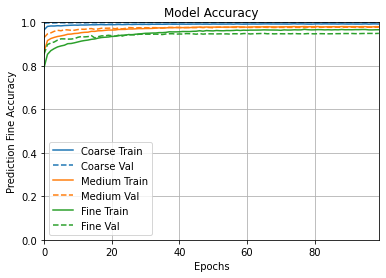

In [17]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

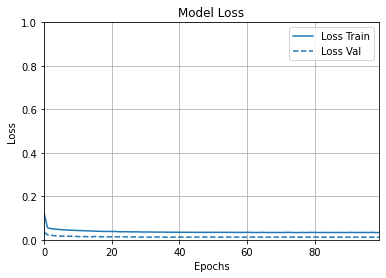

In [18]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [19]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 7s 16ms/step - loss: 0.0246 - prediction_coarse_loss: 9.3631e-04 - prediction_medium_loss: 0.0178 - prediction_fine_loss: 0.0415 - prediction_coarse_accuracy: 0.9990 - prediction_medium_accuracy: 0.9778 - prediction_fine_accuracy: 0.9494
1. loss ==> 0.024609655141830444
2. prediction_coarse_loss ==> 0.0009363139397464693
3. prediction_medium_loss ==> 0.017755206674337387
4. prediction_fine_loss ==> 0.04145485907793045
5. prediction_coarse_accuracy ==> 0.9990000128746033
6. prediction_medium_accuracy ==> 0.9778000116348267
7. prediction_fine_accuracy ==> 0.949400007724762
313/313 [==============================] - 4s 10ms/step


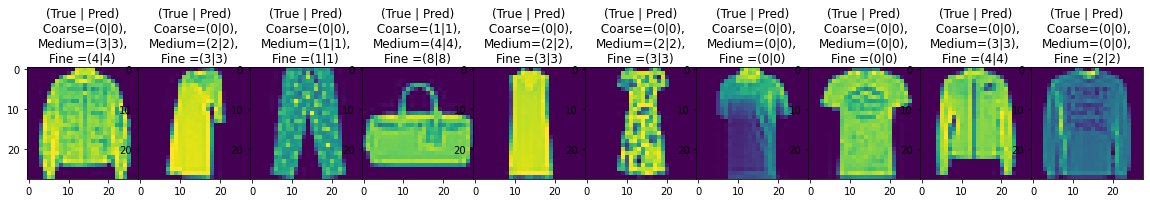

In [20]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[5992    8]
 [   2 3998]]

  • MEDIUM LEVEL 
[[2912    2   23   55    8    0]
 [   2  991    4    2    1    0]
 [  41    3  944   12    0    0]
 [  58    0    8  934    0    0]
 [   2    0    0    0  998    0]
 [   1    0    0    0    0 2999]]

  • FINE LEVEL 
[[902   1  14  10   0   0  68   0   5   0]
 [  0 992   0   3   2   0   2   0   1   0]
 [ 15   1 926   6  23   0  29   0   0   0]
 [ 13   3   4 944  12   0  24   0   0   0]
 [  1   0  25   9 940   0  25   0   0   0]
 [  0   0   0   0   0 992   0   5   0   3]
 [ 74   0  33  10  35   0 846   0   2   0]
 [  0   0   0   0   0   4   0 983   0  13]
 [  0   1   0   0   0   0   1   0 998   0]
 [  0   0   0   0   0   5   0  23   1 971]]

  • Classification Report 


  • COARSE LEVEL 


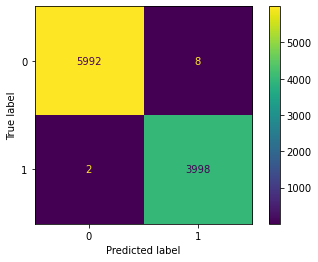

              precision    recall  f1-score   support

           0    0.99967   0.99867   0.99917      6000
           1    0.99800   0.99950   0.99875      4000

    accuracy                        0.99900     10000
   macro avg    0.99883   0.99908   0.99896     10000
weighted avg    0.99900   0.99900   0.99900     10000


  • MEDIUM LEVEL 


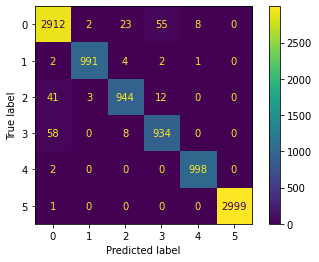

              precision    recall  f1-score   support

           0    0.96552   0.97067   0.96809      3000
           1    0.99498   0.99100   0.99299      1000
           2    0.96425   0.94400   0.95402      1000
           3    0.93121   0.93400   0.93260      1000
           4    0.99106   0.99800   0.99452      1000
           5    1.00000   0.99967   0.99983      3000

    accuracy                        0.97780     10000
   macro avg    0.97450   0.97289   0.97367     10000
weighted avg    0.97780   0.97780   0.97779     10000


  • FINE LEVEL 


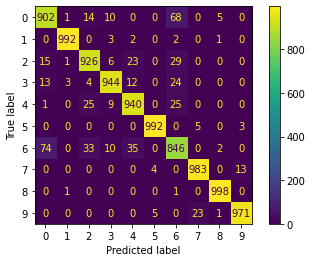

              precision    recall  f1-score   support

           0    0.89751   0.90200   0.89975      1000
           1    0.99399   0.99200   0.99299      1000
           2    0.92415   0.92600   0.92507      1000
           3    0.96130   0.94400   0.95257      1000
           4    0.92885   0.94000   0.93439      1000
           5    0.99101   0.99200   0.99150      1000
           6    0.85025   0.84600   0.84812      1000
           7    0.97230   0.98300   0.97762      1000
           8    0.99106   0.99800   0.99452      1000
           9    0.98379   0.97100   0.97735      1000

    accuracy                        0.94940     10000
   macro avg    0.94942   0.94940   0.94939     10000
weighted avg    0.94942   0.94940   0.94939     10000



In [21]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [22]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.9753233333333333 
Hierarchical Recall = 0.9756666666666666 
Hierarchical F1-Score = 0.9754690476190477 
Consistency =  0.9981 
Exact Match =  0.9486
